In [1]:
# IMPORTANDO LIBRERIAS
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc

Text(0, 0.5, 'Amplitude (Cuentas)')

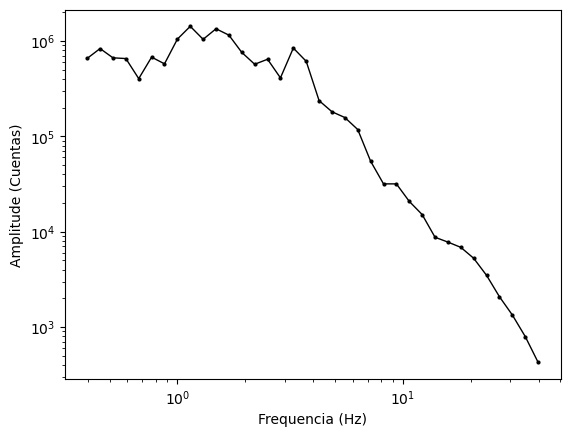

In [41]:
# Cargar los datos
file_name = 'Spectra_M68.txt'  #nombre del archivo a leer
freq_data, amp_data = np.loadtxt(file_name, dtype=float, delimiter=' ', usecols=(0, 1), unpack=True)

# Cargar los datos
file_name = 'Spectra_M68.txt'
freq_data, amp_data = np.loadtxt(file_name, dtype=float, delimiter=' ', usecols=(0, 1), unpack=True)

# Interpolemos para tener menos muestras bien repartidas
f_axis_interp = np.linspace(-0.4,1.6,36)
logf = 10.**f_axis_interp
logf_sin_interpolar = freq_data

# interpolacion de las amplitudes en las frequencias que quiero
amp_data_interp = np.interp(logf, freq_data, amp_data)


# Graficamos el espectro
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(1,1,1)

# logaritmo en 2d para la grafica
#ax1.loglog(logf_sin_interpolar, amp_data, c='blue', marker='.', lw=0.5, markersize=10)
ax1.loglog(logf, amp_data_interp, c='black', marker='.', markersize=4, lw=1)
#ax1.set_title('Espectro de amplitudes')
ax1.set_xlabel('Frequencia (Hz)')
ax1.set_ylabel('Amplitude (Cuentas)')
#ax1.set_xlim([1,2])

In [72]:
# MCMC aplicado a regresiones lineales de la forma: %
#       y = ax + b
# params:  [a, b]
# data:    y
#
# Aunque el modelo del espectro de desplazameinto es
# de la forma u(f) = Omega_0 / (1 + (f/fc)^n)
# el modelo se puede reformular de tal forma que
# log(u(f)) = log(Omega_0) - log(1 - (f/fc)^n)
# lo cual permite tratarlo como la forma general
# y = ax + b

# Definimos el máximo número de iteraciones
itermax = 1000

#expected noise in the data
sd = 2   # desviación estándar de los datos "y"

#distribución uniforme para el parámetro "a" = log(Omega_0)
#Omega_0   10^-1 to 10^15
mina = -1
maxa = 15

# Definimos las funcion uniforme de distribution
#val_omega = np.random.uniform(low=mina, high=maxa)

#distribución uniforme para el parámetro "b" = fc
#fc
minb = 0.01;
maxb = 15;

# Definimos las funcion uniforme de distribution
#val_fc = np.random.uniform(low=minb, high=maxb)



In [73]:
# Modelo de Brune del espectro
def modelo (f, q0, fc):
    # change model for the one you want
    y = np.zeros((1, len(f)), dtype=float)
    for i in range(len(f)):
        # y(i) = q0 / (1 + (f(i)/fc)^3 );
        y[0][i] = np.log(q0) - (np.log(1 + (f[i]/fc)**3.))
    return y[0]

def likelihood(x, y, a, b, ssdd):
    #computes the logarithm likelihood probability

    #model for prediction
    pred = modelo(x, a, b)
    
    #likelihood
    likeli = np.log(sc.stats.norm.pdf(np.log(y),pred,sd))
    sumll = sum(likeli)
    y = np.log(y)
    cost =  np.matmul((y - pred).T, (y - pred))
    result = [sumll, cost];
    
    return result

def grafica_iteracion(f, amp_data, iteracion, label, color_iter, sd_option, p_iter, m_iter):
    # Graficamos el espectro
    fig2 = plt.figure(1)
    ax1 = fig2.add_subplot(1,1,1)

    ax1.loglog(f, amp_data, c='black', marker='.', markersize=8, label='Datos')
    ax1.set_title('Espectro de amplitudes')
    ax1.set_xlabel('Frequencia (Hz)')
    ax1.set_ylabel('Amplitude (Cuentas)')
    ax1.loglog(f, np.exp(iteracion), label=label, color=color_iter, lw=2, marker='.', markersize=5)
    
    if sd_option == True:
        ax1.loglog(f, np.exp(p_iter), c='gray', marker='.', markersize=8, label='Media+std')
        ax1.loglog(f, np.exp(m_iter), c='gray', marker='.', markersize=8, label='Media-std')

    ax1.legend()
    
def priors(a,b,mina,maxa,minb,maxb):
  
    #estimate the prior probability in logarithms

    priora = np.log(sc.stats.uniform.pdf(a,mina,maxa))
    priorb = np.log(sc.stats.uniform.pdf(b,minb,maxb))
    prior = priora + priorb

    return prior


/tmp/ipykernel_18156/801551039.py:46: RuntimeWarning: divide by zero encountered in log
  priora = np.log(sc.stats.uniform.pdf(a,mina,maxa))


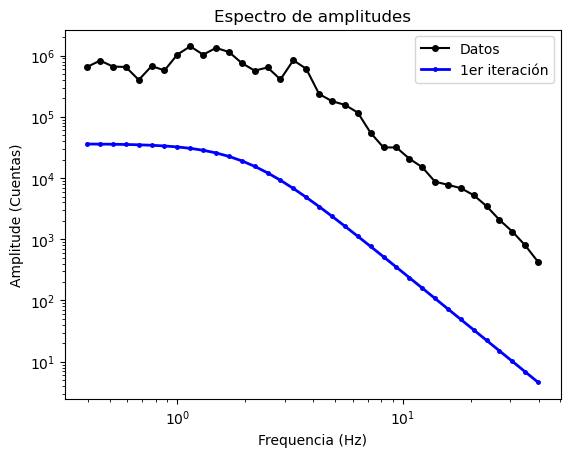

In [122]:
# maximo de iteraciones
itermax = 2000

# Primera predicción de la solución
params = np.zeros((itermax+1, 2), dtype=float)
params[0][:] = np.array([np.exp(10.5), 2])

# Graficamos primera iteración
primera_iter = modelo(logf, params[0][0], params[0][1])
grafica_iteracion(f=logf, amp_data=amp_data_interp, iteracion=primera_iter, label='1er iteración', color_iter='blue', sd_option=False, p_iter=primera_iter, m_iter=primera_iter)

t = np.zeros((1, 2), dtype=float)

# Ciclo sobre el número de iteraciones
for i in range(itermax):

    # Estimamos la probabilidad del estado actual
    like = likelihood(logf, amp_data_interp, params[i][0], params[i][1], sd)
    #print(like, 'likeli')
    prio = priors(np.log(params[i][0]),params[i][1],mina,maxa,minb,maxb)
    #print(prio, 'prior')
    pi = like[0]+prio
    #print('total prob inicial omega_0', pi)

    #propose new state based on current state
    t[0][0] = (mina + (maxa-mina) * np.random.rand(1,1))
    #print(t[0][0])
    # Estimamos la probabilidad del estado actual
    like = likelihood(logf, amp_data_interp, np.exp(t[0][0]), params[i][1], sd)
    #print(like, 'likeli')
    prio = priors(t[0][0],params[i][1],mina,maxa,minb,maxb)
    #print(prio, 'prior')
    pf = like[0]+prio
    #print('total prob final omega_0', pf)
    
    #ratio between probabilities
    r = np.exp(pf-pi)
    #random number from uniform distribution
    u = np.random.uniform(0.8,1)
    #print(r,u, 'r, u')
    #accept-reject criteria
    if ( u < r ):   #accept
        params[i+1][0] = np.exp(t[0][0])
        #print('acepta omega_0')
    else:           #reject
        params[i+1][0] = params[i][0]
        #print('rechaza omega_0')

    #take new proposal
    t[0][1] = (minb + (maxb-minb) * np.random.rand(1,1))

    # Estimamos la probabilidad del estado actual
    like = likelihood(logf, amp_data_interp, params[i+1][0], params[i][1], sd)
    #print(like, 'likeli')
    prio = priors(np.log(params[i+1][0]),params[i][1],mina,maxa,minb,maxb)
    #print(prio, 'prior')
    pi = like[0]+prio
    #print('total prob inicial fc', pi)

    # Estimamos la probabilidad del estado actual
    like = likelihood(logf, amp_data_interp, params[i+1][0], t[0][1], sd)
    #print(like, 'likeli')
    prio = priors(np.log(params[i+1][0]),t[0][1],mina,maxa,minb,maxb)
    #print(prio, 'prior')
    pf = like[0]+prio
    #rint('total prob final fc', pf)
    
    #ratio between probabilities
    r = np.exp(pf-pi)
    #random number from uniform distribution
    u = np.random.uniform(0.8,1)
    #print(r,u, 'r, u')

    #accept-reject criteria
    if ( u < r ):   #accept
        params[i+1][1] = t[0][1]
        #print('acepta fc')
    else:           #reject
        params[i+1][1] = params[i][1]
        #print('rechaza fc')


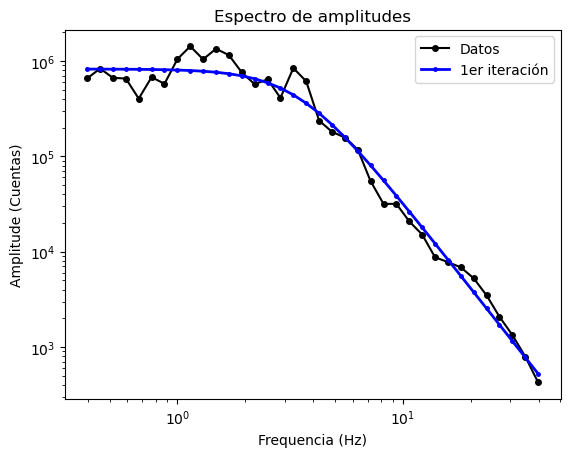

In [123]:
# Graficamos primera iteración
ultima_iter = modelo(logf, params[itermax][0], params[itermax][1])
grafica_iteracion(f=logf, amp_data=amp_data_interp, iteracion=ultima_iter, label='1er iteración', color_iter='blue', sd_option=False, p_iter=primera_iter, m_iter=primera_iter)


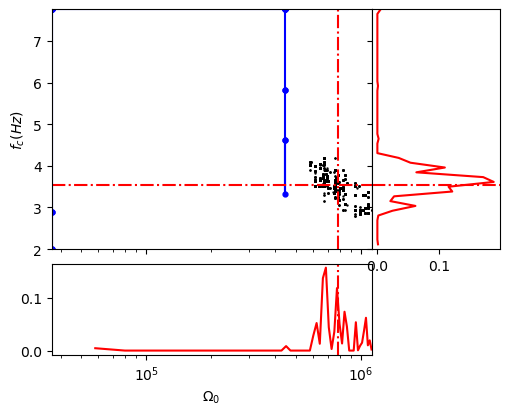

In [124]:
fig3 = plt.figure(3)
ax3 = fig3.add_subplot(1, 3, 1)
ax3.set_position([0.1,0.3, 0.5, 0.5])
    
burn = 100

data_x = []
for i in range(itermax):
    data_x.append(params[i][0])
# getting data of the histogram
count_x, bins_count_x = np.histogram(data_x, bins=50)
# finding the PDF of the histogram using count values
pdf_x = count_x / sum(count_x)  
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf_x = np.cumsum(pdf_x)

data_y = []
for i in range(itermax):
    data_y.append(params[i][1])
# getting data of the histogram
count_y, bins_count_y = np.histogram(data_y, bins=50)
# finding the PDF of the histogram using count values
pdf_y = count_y / sum(count_y)  
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf_y = np.cumsum(pdf_y)


# plotting PDF and CDF

for i in np.arange(burn+1, itermax):
    ax3.scatter(params[i][0], params[i][1], 0.5, color='black')

x = []
y = []
for i in range(20):
    x.append(params[i][0])
    y.append(params[i][1])
ax3.plot(x, y, 2, color='blue', marker='.', markersize=7)
ax3.set_xlim([np.min(data_x), np.max(data_x)])
ax3.set_ylim([np.min(data_y), np.max(data_y)])
ax3.set_xscale('log')
ax3.set_xticklabels([])
ax3.set_ylabel(r'$f_c (Hz)$')


ax4 = fig3.add_subplot(1, 3, 2)
ax4.set_position([0.1,0.08, 0.5, 0.19])
ax4.plot(bins_count_x[1:], pdf_x, color="red", label="PDF_x")
ax4.set_xlim([np.min(data_x), np.max(data_x)])
ax4.set_xscale('log')
ax4.set_xlabel(r'$\Omega_0$')


ax5 = fig3.add_subplot(1, 3, 3)
ax5.set_position([0.6,0.3, 0.2, 0.5])
ax5.plot(pdf_y, bins_count_y[1:], color="red", label="PDF_y")
#plt.plot(bins_count[1:], cdf, label="CDF")
ax5.set_yticklabels([])
ax5.set_ylim([np.min(data_y), np.max(data_y)])

mx = np.zeros((itermax-burn), dtype=float)
my = np.zeros((itermax-burn), dtype=float)
for i in range(itermax-burn):
    mx[i] = data_x[i+burn]
    my[i] = data_y[i+burn]

mean_omega = np.mean(mx)
mean_fc = np.mean(my)
sd_omega = np.std(mx)
sd_fc = np.std(my)

# specifying horizontal line type
ax3.axhline(y = mean_fc, color = 'r', linestyle = '-.', label='Media')
ax3.axvline(x = mean_omega, color = 'r', linestyle = '-.')

ax4.axvline(x = mean_omega, color = 'r', linestyle = '-.')
ax5.axhline(y = mean_fc, color = 'r', linestyle = '-.')


0.30703739381299655
781787.6793446824 924314.1080695152
3.54184148655084 3.234804092737843


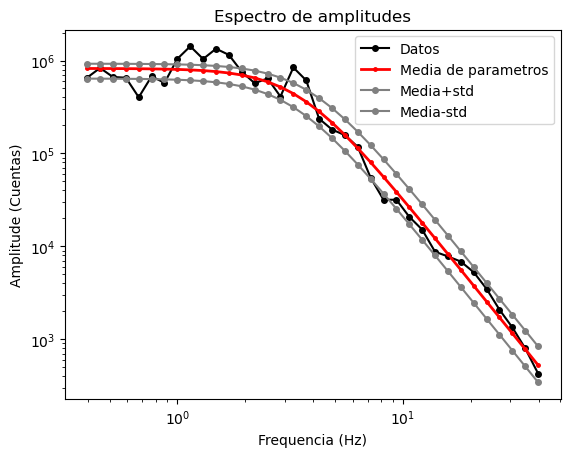

In [125]:
print(sd_fc)
# Graficamos primera iteración
print(mean_omega, mean_omega+sd_omega)
print(mean_fc, mean_fc-sd_fc)
#grafica_iteracion(f=logf, amp_data=amp_data_interp, iteracion=mean_iter, label='Media', color_iter='blue', sd_option=True, mean_omega=mean_omega, mean_fc=mean_fc, sd_omega=sd_omega, sd_fc=sd_fc)
p_iter = modelo(logf, mean_omega+sd_omega, mean_fc+sd_fc)
m_iter = modelo(logf, mean_omega-sd_omega, mean_fc-sd_fc)

grafica_iteracion(f=logf, amp_data=amp_data_interp, iteracion=ultima_iter, label='Media de parametros', color_iter='red', sd_option=True, p_iter=p_iter, m_iter=m_iter)

